# 決算短信HTMLの読み取り可否状況レポート (全社)

決算短信のHTML化を実施している企業1330社のうち、ランダムに1045社をサンプリングしHTMLファイルの読み取り可否状況を調査する。  
対象とするのは4-5月に開示されたHTMLとする。3月末決算の会社は本決算で、それ以外の会社は四半期の決算となり、四半期についてはセグメント情報が省略されるケースが多い点には留意が必要。

## 検証方法

各社のHTMLファイルを実際に読み込み、8つのステータスをチェックする。以下に、ステータスとプログラム上での表記を列記する。

1. 「報告セグメント」を含むテーブルが存在しない (`segment_table_not_exist`)
2. 「報告セグメント」を含むテーブルが1つしか存在しない (`too_little_segment_table`)
3. 「報告セグメント」を含むテーブルが前期と当期の3つ以上存在する (`too_much_segment_tables`)
4. テーブルの報告時期を示すテキストが存在しない (`period_not_found`)
5. 「報告セグメント」のテーブルからセグメントが取得できない (`segment_not_found`)
6. 「報告セグメント」のテーブルから売上・利益の勘定が取得できない (`account_not_found`)
7. 「報告セグメント」のテーブルから指定したセグメント、勘定のデータが読み取れない (`value_read_failed`)
8. 4~6のエラーなく読み取れた前期・当期のテーブルが存在する (`completed`)

`data/raw/HTML_ALL` 配下にあるファイルを一つ一つ読み込んでいき、ステータスをチェックする。

* `HTML_ALL` の内部には`qualitative_(銘柄コード)_開示年月日時刻.htm`形式のファイルが保存されていると想定する。
   * `HTML_ALL` はサイズが大きいため、Gitリポジトリの中には含まれない。
* 銘柄名は、`external/companies.csv` から取得する。
* 報告時期がなくセグメントも取得できない、などステータスは複数チェックされる可能性がある。
* 報告セグメントを含むテーブルが3つ以上ある場合でも(3)、4~7のエラーが発生せず読み取れた前期と当期のテーブルがある場合8がチェックされる。

## 検証

はじめに、HTMLファイルを読み込むためのライブラリとモジュール (`financial_result_to_dataframe`) を読み込む。

In [1]:
import sys
import dataclasses
from pathlib import Path
if "../" not in sys.path:
    sys.path.append("../")
import pandas as pd
from scripts.financial_result_to_dataframe import financial_result_to_dataframe

In [2]:
%load_ext autoreload
%autoreload 2

銘柄コードを名称に変換する辞書を作成する。

In [3]:
security_code_df = pd.read_csv(Path.cwd().joinpath("../data/external/companies.csv"))
security_code_dict = dict(zip(security_code_df.security_code.apply(str).tolist(), security_code_df.security_name.tolist()))

各HTMLファイルを読み込みステータスをチェックする。

In [4]:
data_dir = Path.cwd().joinpath("../data/raw/HTML_ALL")
company_dfs = {}
read_results = []

for file in data_dir.iterdir():
    if file.is_file():
        security_code = file.name.split("_")[1]
        if security_code in security_code_dict:
            security_name = security_code_dict[security_code]
        else:
            print(f"{security_code} is unknown.")
            continue
        
        company_name = f"{security_name} ({security_code})"
        try:
            df, log = financial_result_to_dataframe(file)
            _result = dataclasses.asdict(log.status)
            for key in _result:
                _result[key] = 1 if _result[key] else 0 # Boolをintに変更
            _result["company_name"] = company_name
            if company_name not in company_dfs:
                company_dfs[company_name] = df
                read_results.append(_result)
        except Exception as ex:
            print(f"{company_name}({security_code}): {ex}")

read_result_df = pd.DataFrame(read_results).set_index("company_name")

18410 is unknown.
大東建託株式会社 (18780)(18780): list index out of range
川本産業株式会社 (36040)(36040): list index out of range
ＪＳＲ株式会社 (41850)(41850): list index out of range
87660 is unknown.


In [5]:
len(read_result_df)

1030

## 検証結果

1030件のうち、537件(52%)は正常に読み取ることに成功している。「「報告セグメント」を含むテーブルが存在しない」は、410件(39%)となっている。

報告セグメントを含むテーブルがない場合に考えられる理由は次のようなものがある。

* 単一セグメントである
* 通期の報告でないため記載していない
* 「「報告セグメント」を含むテーブル」で開示をしていない

報告セグメントを含んでいる開示は620件であり(全1030件から410件を差し引いた数)、このうち537件が正常に読み取れていたことから8割超(86%)は今回のプログラムで正常に読み取れたことがわかる。

<AxesSubplot:>

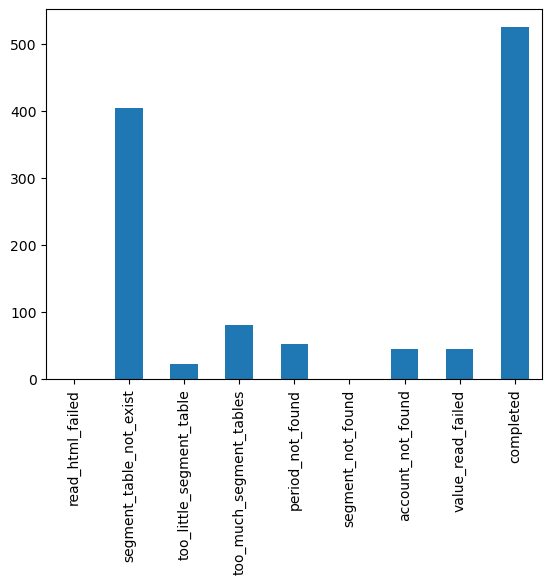

In [13]:
read_result_df.sum().plot.bar()

In [7]:
read_result_df.sum()

read_html_failed              0
segment_table_not_exist     405
too_little_segment_table     22
too_much_segment_tables      80
period_not_found             52
segment_not_found             0
account_not_found            44
value_read_failed            44
completed                   526
dtype: int64

前期、当期のテーブルがエラーなく読み取れた企業は以下のとおりである(10件のみ表示)。

In [8]:
read_result_df[read_result_df.completed == 1].head(10).style.applymap(lambda x: "background-color: coral" if x > 0 else None)

,read_html_failed,segment_table_not_exist,too_little_segment_table,too_much_segment_tables,period_not_found,segment_not_found,account_not_found,value_read_failed,completed
company_name,,,,,,,,,
日本水産株式会社 (13320),0,0,0,0,0,0,0,0,1
マルハニチロ株式会社 (13330),0,0,0,0,0,0,0,0,1
株式会社 サカタのタネ (13770),0,0,0,0,0,0,0,0,1
ホクト株式会社 (13790),0,0,0,0,0,0,0,0,1
技研ホールディングス株式会社 (14430),0,0,0,0,0,0,0,0,1
Ｍ－ＩＴｂｏｏｋＨＤ (14470),0,0,0,0,0,0,0,0,1
株式会社ＦＵＪＩジャパン (14490),0,0,0,0,0,0,0,0,1
住石ホールディングス株式会社 (15140),0,0,0,0,0,0,0,0,1
三井松島ホールディングス株式会社 (15180),0,0,0,0,0,0,0,0,1


セグメント報告のテーブルが存在するものの、読み取れなかった企業は次のような企業である。

In [9]:
read_result_df[(read_result_df.completed == 0) & (read_result_df.segment_table_not_exist == 0)]\
    .style.applymap(lambda x: "background-color: coral" if x > 0 else None)

,read_html_failed,segment_table_not_exist,too_little_segment_table,too_much_segment_tables,period_not_found,segment_not_found,account_not_found,value_read_failed,completed
company_name,,,,,,,,,
石油資源開発株式会社 (16620),0,0,0,0,0,0,0,1,0
中小企業ＨＤ (17570),0,0,0,0,0,0,0,1,0
株式会社富士ピー・エス (18480),0,0,1,0,0,0,0,0,0
名工建設株式会社 (18690),0,0,0,0,1,0,0,0,0
株式会社夢真ビーネックスグループ (21540),0,0,0,1,0,0,0,0,0
テラ株式会社 (21910),0,0,0,1,1,0,1,1,0
（株）サイネックス (23760),0,0,0,0,1,0,0,0,0
株式会社 オプトホールディング (23890),0,0,0,0,1,0,0,0,0
株式会社 エスプール (24710),0,0,0,1,1,0,1,0,0


**報告セグメントのテーブルが少ない例: 株式会社富士ピー・エス (18480)**

当期に駿河技建株式会社を買収し初めての連結財務諸表となるため、前期の報告がない。

![error_example_11.png](images/error_example_11.png)

**報告セグメントのテーブルが多すぎる例: 株式会社夢真ビーネックスグループ (21540)**

前期・当期以外のセグメントごとの報告(収益認識関係)がある。

![error_example_12.png](images/error_example_12.png)

前期・当期以外のセグメントごとの報告があると、セグメント/勘定の読み取りに失敗する。、

**期間の記述がない/取得できない例: 名工建設株式会社 (18690)**

和暦で記載がされている。

![error_example_13.png](images/error_example_13.png)

ソフトバンクは独特な期間の書き方をしている。

![error_example_04.png](images/error_example_04.png)

**値が読み取れない例: ジャパンフーズ株式会社 (25990)**

数値以外の表記が含まれる。

![error_example_14.png](images/error_example_14.png)

サンプリングした中では、利益の書き方、前期の報告有無がデータの取得可否を分けている。「報告セグメント」を含むテーブルによる報告はおおむね統一されていると見える。一方で、「報告セグメント」を含まないテーブルでセグメント報告をしている企業には注意が必要である。

セグメント報告の様式を整え、勘定のテキストや行の記載を形式化すればさらにデータが取得できるようになることが期待される。